In [ ]:
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import bootstrapped.bootstrap as bs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn

In [119]:
# Latex Configuration
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
fontpath = os.path.expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

In [ ]:
import sys
import os.path
# Local Modules
sys.path.insert(0, os.path.abspath('/scratch/horta/coronatwitter/'))
from helpers.vars import categories_coarse, categories_final, types, langs, lang_names, nicer_words,\
                         remove_not_in_english, coarsify_category
from helpers.df import get_avg, matching_dataframe_categorical
from helpers.plot import set_size, plot_categorical_balance
from helpers.analysis import caliper_matching

In [ ]:
# Change this!
path = "/dlabdata1/gligoric/Coronatwitter/"
# ------------

## Loads data!

In [ ]:
#this loads the annotated users and all their tweets!
df_annotated = pd.read_pickle(path + 'V2_annotated_users.pickle')
df_stream = pd.read_pickle(path + 'datasets/covid_stream_all_tweets_sampled_usersv2.pickle')

# small fix
df_stream['user.screen_name'] = df_stream['user.screen_name'].astype(str)
df_annotated['username'] = df_annotated['username'].astype(str)

# merge the two on screen_name, merge on the annotated
df_merged = df_stream.merge(df_annotated, left_on='user.screen_name', right_on='username', 
                how = 'right')

# gets average
df = get_avg(df_merged, categories_coarse, types)
df = df.drop("index", axis=1)

In [183]:
def simplify(df_):
    to_drop = ['id', 'text', 'created_at', 'user.id',"user.statuses_count", 'user.name', 'user.description', 
           'user.timezone', 'user.location', 'user.num_followers', 'user.num_following', 'user.created_at', 
           'matched_keywords', 'longitude', "lang", 'latitude', 'country_code', 'region', 'subregion', 'geo_type', 
           'num_quotes',  'num_replies', 'bio', "n_retweets", 'screenname', 'type1', 'type2', 'type3', 'type4', 
           "username", "coarsetype1", "coarsetype2", "coarsetype3", "coarsetype4", 'category1', 'category2', 
           'category3', 'category4', 'workerID1', 'workerID2', 'workerID3', 'workerID4']
    
    df_simple = df_.drop(to_drop, axis=1)

    num_tweets_dict = dict(df_simple.groupby("user.screen_name")["n_covid_tweeting_language"].count())
    df_simple["num_tweets"] = df_simple["user.screen_name"].apply(lambda x: num_tweets_dict[x])
    quantiles_dict = dict(df_simple.groupby(["n_covid_tweeting_language"])["num_retweets"].apply(
                            lambda x: np.quantile(x, 0.99)))

    df_simple["top1"] = df_simple.apply(lambda x: x["num_retweets"] >= quantiles_dict[x["n_covid_tweeting_language"]],
                                        axis=1)
    df_simple = df_simple.groupby("user.screen_name").max().reset_index()
    df_simple = df_simple.dropna(subset=["estimated_coarse_majority_category", "n_followers", 
                             "n_covid_tweeting_language", "num_tweets"]).reset_index()
    return df_simple


is_x = (df["Individual:Male_avg"] +\
        df["Individual:Female_avg"] +\
        df["Individual: Other gender or unclear_avg"] >= 0.5)
is_y = df["Institution_avg"]  >= 0.5
condition = (is_x | is_y) & ~(is_x & is_y)
df_individual_institution =  df.loc[condition, :]
df_individual_institution.loc[:, "treat"] = is_y
df_individual_institution = simplify(df_individual_institution)

/scratch/horta/anaconda3/envs/overall/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/scratch/horta/anaconda3/envs/overall/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [184]:
sum(df_individual_institution.top1)/len(df_individual_institution)

0.07846973155091838

In [185]:
df_individual_institution

,index,user.screen_name,num_retweets,n_followers,n_covid_tweeting_language,estimated_coarse_type,estimated_gender,coarsecat1,coarsecat2,coarsecat3,...,Sport_avg,Other_avg,Individual:Male_avg,Institution_avg,Individual: Other gender or unclear_avg,Unclear_avg,Individual:Female_avg,treat,num_tweets,top1
0,0,000alotaibi,33,41439,ar,Individual,Individual: Other gender or unclear,[Media],[Other],[Media],...,0.0,0.50,0.25,0.25,0.50,0.00,0.0,False,10,False
1,1,0153_you,13,18782,ja,Individual,Individual: Other gender or unclear,[Art],[Other],[Art],...,0.0,0.25,0.00,0.00,0.75,0.00,0.0,False,1,False
2,2,02ShopIYN41g7,25,699,ja,Institution,NaN,[Business],[Art],[Art],...,0.0,0.00,0.00,0.75,0.00,0.00,0.0,True,2,False
3,3,04Carmen20,33,2227,it,Individual,Individual:Female,[Other],"[Media, Science]",[Other],...,0.0,0.50,0.25,0.00,0.25,0.00,0.5,False,12,False
4,4,060gobes,10,19550,es,Institution,NaN,[Government and Politics],"[Business, Public Services, Science]",[],...,0.0,0.00,0.00,1.00,0.00,0.00,0.0,True,7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9196,9943,zodiac0088,34,9767,ja,Individual,Individual: Other gender or unclear,[Outspoken Political Supporter],[Other],[Other],...,0.0,0.50,0.00,0.25,0.50,0.00,0.0,False,17,False
9197,9944,zopitaux,27,2106,fr,Individual,Individual:Male,[Media],[Healthcare],"[Healthcare, Media]",...,0.0,0.00,0.50,0.25,0.00,0.25,0.0,False,1,False
9198,9945,zuckerguss1998,7073,14,de,Individual,Individual: Other gender or unclear,[Outspoken Political Supporter],[Other],[Other],...,0.0,0.75,0.25,0.25,0.25,0.25,0.0,False,23,True
9199,9946,zuugaabee,10,653,de,Individual,Individual:Male,[Other],[Other],[Other],...,0.0,0.75,0.50,0.00,0.00,0.25,0.0,False,7,False


## Propensity Score Classifier 

institution
Accuracy: 0.7889359852189979


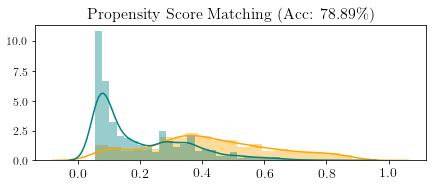

In [186]:
def psc(df_simple):
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import OrdinalEncoder
    fig, ax = plt.subplots(1, figsize=(7, 2.5))

    X_ = df_simple.loc[:, [ 
              "estimated_coarse_majority_category", 
              "n_followers", 
              "n_covid_tweeting_language", 
              "num_tweets"]]
    y_ = df_simple.loc[:, ["treat"]]
    enc_x = OrdinalEncoder()

    X_["n_covid_tweeting_language"] = \
        enc_x.fit_transform(X_.n_covid_tweeting_language.values.reshape(-1, 1)).reshape(-1)
    X_["estimated_coarse_majority_category"] = \
        enc_x.fit_transform(X_.estimated_coarse_majority_category.values.reshape(-1, 1)).reshape(-1)
    X= X_
    enc_y = OrdinalEncoder()
    y = enc_y.fit_transform(y_)
    y = y.reshape(len(y),)

    clf = GradientBoostingClassifier(n_estimators=200, max_depth=1, subsample=0.5).fit(X, y)
    # clf = GradientBoostingClassifier(n_estimators=1000, max_depth=3, subsample=0.5).fit(X, y)
    # clf = LogisticRegression().fit(X,y)
    propensities = clf.predict_proba(X)
    acc = clf.score(X, y)
    print("Accuracy:", clf.score(X, y))
    ax.set_title("Propensity Score Matching (Acc: {}\%)".format(str(round(100* acc,2 ))))
    sns.distplot(propensities[:, 1][y == 1], ax=ax, color="orange")
    sns.distplot(propensities[:, 1][y == 0], ax=ax, color="teal")
    plt.show()

    return propensities[:, 1]


print("institution")
df_individual_institution["Propensity_score"] = psc(df_individual_institution)

## Caliper Matching

In [187]:
# Does matching 
np.random.seed(1)
matching_individual_institution = caliper_matching(df_individual_institution['treat'], 
                                                   df_individual_institution['Propensity_score'], 
                                                   caliper=0.05, replace=False)

In [188]:
def get_nicer_dataframes(df_simple, matching, treat, contr):
    
    match1 = np.array(list(matching.keys()))
    match2 = np.array([matching[k] for k in list(matching.keys())])
    df_matched = pd.concat([df_simple.iloc[match1].reset_index(drop=True), 
                            df_simple.iloc[match2].reset_index(drop=True)], axis=1)
    df_matched.columns = [c + "_x" for c in df_matched.columns[:len(df_matched.columns)//2]] + \
                         [c + "_y" for c in df_matched.columns[len(df_matched.columns)//2:]]

    df_matched.to_pickle("/dlabdata1/gligoric/Coronatwitter/df_matched_treat_{}_contr_{}.p".format(treat, contr))

    df_matched_flat = pd.concat([df_simple.iloc[match1].reset_index(drop=True), 
                              df_simple.iloc[match2].reset_index(drop=True)], axis=0)

    df_matched_flat.to_csv("/dlabdata1/gligoric/Coronatwitter/df_matched_flat_treat_{}_contr_{}.csv".format(treat, 
                                                                                                            contr),
                           index=False)

    df_matched[["num_retweets_y", "num_retweets_x"]]\
        .to_csv("/dlabdata1/gligoric/Coronatwitter/rts_matched_treat_{}_contr_{}.csv".format(treat, contr),
                 index=False)

    df_matched[["top1_y", "top1_x"]].astype(float)\
        .to_csv("/dlabdata1/gligoric/Coronatwitter/top1_matched_treat_{}_contr_{}.csv".format(treat, contr),
                 index=False)
    
    return df_matched, df_matched_flat
    
matched_individual_institution, matched_flat_individual_institution = get_nicer_dataframes(
                                                                            df_individual_institution,
                                                                            matching_individual_institution, 
                                                                            "institution", "individual")

# Plots categorical distributions

In [189]:
df_cats = matching_dataframe_categorical(df_individual_institution, 
                                         matched_flat_individual_institution, 
                                         "treat", "estimated_coarse_majority_category")
df_langs = matching_dataframe_categorical(df_individual_institution, 
                                          matched_flat_individual_institution, 
                                          "treat", "n_covid_tweeting_language")

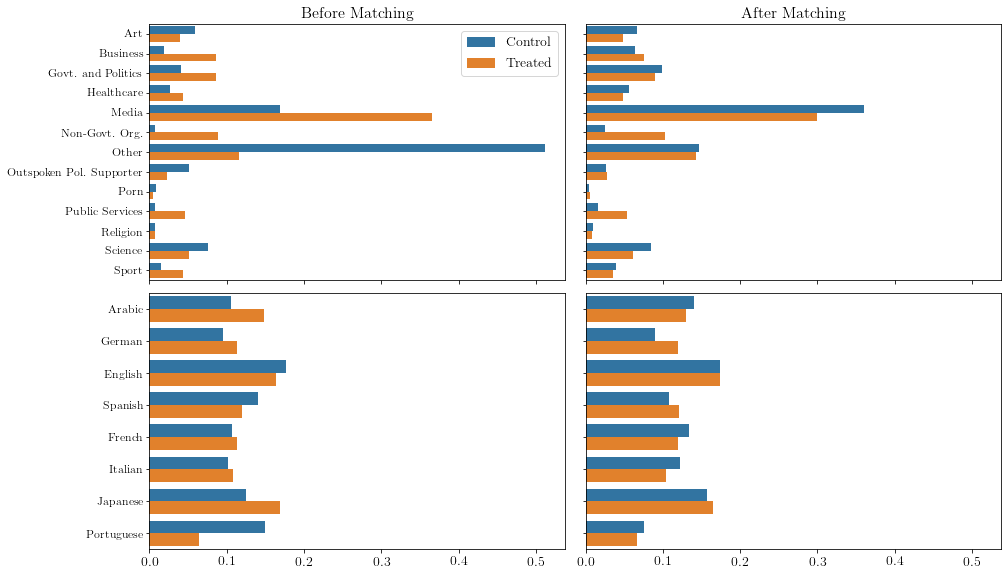

In [190]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True, gridspec_kw={"wspace": 0.05, "hspace": 0.05})

axs = axs.flatten()

sns.barplot(y="index", x="val", hue="group", data=df_cats[df_cats.kind =="Source"],
            orient="h", ax=axs[0], zorder=2)
sns.barplot(y="index", x="val", hue="group", data=df_cats[df_cats.kind =="Matched"], 
            orient="h", ax=axs[1], zorder=2)
axs[0].legend()
axs[1].legend([], fancybox=False, frameon=False, shadow=False)
labels = [nicer_words(c.get_text()) for c in axs[0].get_yticklabels()] 
axs[0].set_yticklabels(labels)
axs[1].set_yticklabels([])
axs[0].set_title("Before Matching")
axs[1].set_title("After Matching")

    
sns.barplot(y="index", x="val", hue="group", data=df_langs[df_langs.kind =="Source"], 
            orient="h", ax=axs[2], zorder=2)
sns.barplot(y="index", x="val", hue="group", data=df_langs[df_langs.kind =="Matched"], 
            orient="h", ax=axs[3], zorder=2)
axs[2].legend([], fancybox=False, frameon=False, shadow=False)
axs[3].legend([], fancybox=False, frameon=False, shadow=False)
axs[2].set_yticklabels([lang_names[l.get_text()] for l in axs[2].get_yticklabels()])
axs[3].set_yticklabels([])

for ax in axs:
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.xaxis.grid()
    ax.xaxis.grid()
set_size(fig, (14, 8))
plt.show()

Ttest_indResult(statistic=-9.85974815780854, pvalue=1.1484345397673685e-22)


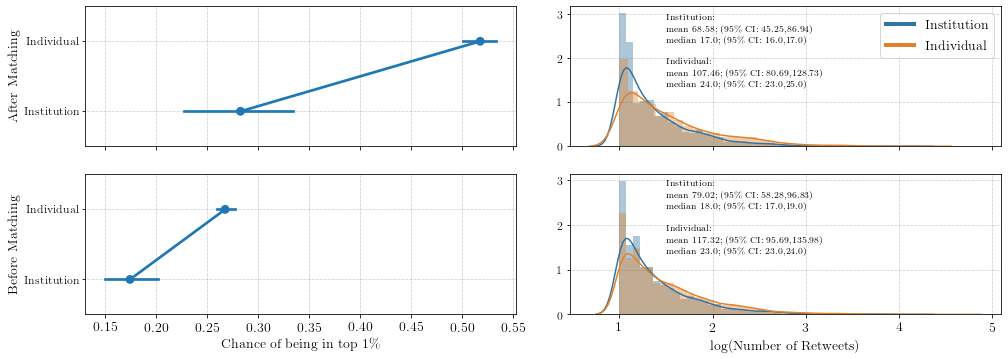

In [191]:
fig, axs = plt.subplots(2, 2, figsize=(14, 5), sharex="col", gridspec_kw={"wspace": 0.125, "hspace": 0.2})
def plot_distr(df_matched, df_matched_flat):

    ax = axs[0, 0]
    sns.pointplot(x="treat", y="top1", data=df_matched_flat, ax=ax, orient="h")
    ax.set_ylabel("After Matching")
    ax.set_yticklabels(["Individual", "Institution"])
    ax.set_xlabel("")

    print(scipy.stats.ttest_ind(np.log(df_matched.num_retweets_x.values), 
                                np.log(df_matched.num_retweets_y.values)))
    
    ax.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)
    ax.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    
    
    ax = axs[0, 1]
    sns.distplot(np.log10(df_matched.num_retweets_x), color="#3374A1", ax=ax)
    sns.distplot(np.log10(df_matched.num_retweets_y), color="#E1812C", ax=ax)

    custom_lines = [Line2D([0], [0], color="#3374A1", lw=4),
                    Line2D([0], [0], color="#E1812C", lw=4)]

    ax.legend(custom_lines, ['Institution', 'Individual',])
    ax.set_xlabel("")

    bt = bs.bootstrap_ab(df_matched.num_retweets_x.values, df_matched.num_retweets_y.values, 
                          bs_stats.mean, bs_compare.difference)
    ax.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)
    ax.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    
        
    idv = 0

    for arr, val in zip([df_matched.num_retweets_x.values, 
                     df_matched.num_retweets_y.values],
                        ["Institution:", "Individual:"]):
        mean = bs.bootstrap(arr, bs_stats.mean)
        median = bs.bootstrap(arr, bs_stats.median)

        ax.text(1.5, 3 - idv, "{} \n".format(val) + r'mean {}; (95\% CI: {},{})'.format(round(mean.value, 2), 
            round(mean.lower_bound, 2), 
            round(mean.upper_bound, 2))
            + "\n" + r'          median {}; (95\% CI: {},{})'.format(
            round(median.value, 2), 
            round(median.lower_bound, 2), 
            round(median.upper_bound, 2))
                , va="top", size=9.5)
        idv += 1
    

    set_size(fig, (14, 5))
    
    
    ax = axs[1, 0]
    
    sns.pointplot(x="treat", y="top1", data=df_individual_institution, ax=ax, orient="h")
    ax.set_ylabel("Before Matching")
    ax.set_yticklabels(["Individual", "Institution"])
    ax.set_xlabel("Chance of being in top 1\%")
    ax.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)
    ax.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    
    ax = axs[1, 1]

    sns.distplot(np.log10(df_individual_institution.loc[df_individual_institution.treat].num_retweets),
             color="#3374A1")
    sns.distplot(np.log10(df_individual_institution.loc[~df_individual_institution.treat].num_retweets),
                 color="#E1812C")
    ax.set_xlabel(r'$\log$' '(Number of Retweets)')
    
    ax.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)
    ax.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    
    
    idv = 0
    for arr, val in zip([df_individual_institution.loc[df_individual_institution.treat].num_retweets.values, 
                     df_individual_institution.loc[~df_individual_institution.treat].num_retweets.values],
                        ["Institution:", "Individual:"]):
        mean = bs.bootstrap(arr, bs_stats.mean)
        median = bs.bootstrap(arr, bs_stats.median)

        ax.text(1.5, 3 - idv, "{} \n".format(val) + r'mean {}; (95\% CI: {},{})'.format(round(mean.value, 2), 
            round(mean.lower_bound, 2), 
            round(mean.upper_bound, 2))
            + "\n" + r'          median {}; (95\% CI: {},{})'.format(
            round(median.value, 2), 
            round(median.lower_bound, 2), 
            round(median.upper_bound, 2))
                , va="top", size=9.5)
        idv += 1
    

    set_size(fig, (14, 5))
    

plot_distr(matched_individual_institution, matched_flat_individual_institution)
fig.savefig('/scratch/horta/coronatwitter/images/matching.pdf', bbox_inches='tight')